# Panel 4 - Optimal Phase Distributions

## N = 7 cells

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from tqdm import tqdm

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("./figure-generating-notebooks/bioAI.mplstyle")

from scipy.spatial import Voronoi, voronoi_plot_2d

from models import RobustSimilitude
from methods import Hexagon

In [3]:
# number of grid cells
N = 7
# number of space samples to evaluate the encodings on
N_space_samples = 2**10

# Hyperparameters
dtype = torch.float32
NO_EPOCHS = 4000
r_jitter_magnitude = 1e-2
p_jitter_magnitude = 0.0

# external parameters
model_path = Path("./saved-models/panel4")

## optimal phases

In [4]:
model = RobustSimilitude(r_magnitude=r_jitter_magnitude, p_magnitude=p_jitter_magnitude, ncells=N, dtype=dtype)

In [5]:
def train_similitude(model: RobustSimilitude, no_epochs: int, model_path: Path, dtype=torch.float32):
    loss_history = []
    Gs = []
    phases_history = [model.phases.clone().detach().numpy()]
    
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            samples_r = model.unit_cell.sample(N_space_samples)
            samples_r = torch.tensor(samples_r, dtype=dtype)
            loss = model.train_step(samples_r)
            G = np.mean(model.metric_tensor(model.jacobian(samples_r)).detach().numpy(), axis=0)
            
            loss_history.append(loss)
            Gs.append(G)
            phases_history.append(model.phases.clone().detach().numpy())
        
    save_dict = {
        "model": model,
        "loss_history": loss_history,
        "metric_tensor_history": Gs,
        "phases_history": phases_history,
    }
    torch.save(save_dict, model_path / Path(f'{type(model).__name__}-{model.ncells}-{no_epochs}.pty'))
            
    return loss_history, Gs, phases_history

In [6]:
loss_history, Gs, phases_history = train_similitude(model, NO_EPOCHS, model_path, dtype=torch.float32)

Training time [epochs]: 100%|████████████████████████████████████| 4000/4000 [00:10<00:00, 374.90epoch/s]


(-0.7333333333333333,
 0.7333333333333333,
 -0.6350852961085885,
 0.6350852961085884)

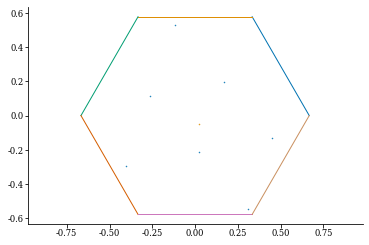

In [7]:
optimal_phases_wrapped = model.unit_cell.wrap(phases_history[-1])

fig, ax = plt.subplots()
ax.scatter(*optimal_phases_wrapped.T)#, markersize=1.0)
ax.scatter(*np.mean(optimal_phases_wrapped, axis=0))
model.unit_cell.plot(fig,ax)
ax.axis("equal")

In [8]:
optimal_phases_wrapped

array([[ 0.16631958,  0.19756004],
       [ 0.30924657, -0.54482939],
       [ 0.02369451, -0.21476753],
       [-0.40500462, -0.29725987],
       [-0.26214907,  0.11511243],
       [-0.1192942 ,  0.52753401],
       [ 0.45211327, -0.1322872 ]])

## vary hexagonal phases in rotation and spacing

In [9]:
res = 100 # resolution
scales = np.linspace(0.0, model.unit_cell.radius, num=res)
orientations = np.linspace(0.0, 60.0, num=res) # degrees
CI_loss = np.ones((len(scales), len(orientations)))

center = np.array([0.0, 0.0])
model = RobustSimilitude(r_magnitude=r_jitter_magnitude, p_magnitude=p_jitter_magnitude, ncells=N, dtype=dtype)
space_samples = model.unit_cell.mesh(res)
hex_phase_set = np.array([])

for s_i, scale in enumerate(scales):
    for o_j, orientation in enumerate(orientations):
        hexagon = Hexagon(scale, orientation, center)
        hex_phase_set = np.concatenate((hexagon.center[None, :], hexagon.hpoints), axis=0)
        model.set_phases(hex_phase_set)
        CI_loss[s_i, o_j] = model.loss_fn(torch.tensor(space_samples, dtype=dtype)).item()

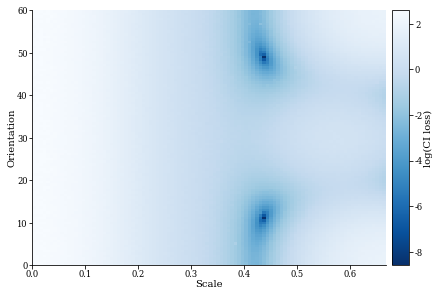

In [10]:
fig = plt.figure(constrained_layout=True)
widths = [1, .05,]
heights = [1,]
heatmap_spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

cmap_reversed = matplotlib.cm.get_cmap('Blues_r')

im_ax = fig.add_subplot(heatmap_spec[0, 0])
im = im_ax.imshow(
    np.log(CI_loss).T, #imshow uses inverted axis (x, y) -> (y, x)
    origin = 'lower',
    extent = [ np.min(scales), np.max(scales), 
                   np.min(orientations), np.max(orientations)],
    cmap = cmap_reversed,
)
im_ax.set_xlabel('Scale')
im_ax.set_ylabel('Orientation')
im_ax.axis('auto')

cmap_ax = fig.add_subplot(heatmap_spec[0, 1])
fig.colorbar(
    im,
    cax=cmap_ax, 
    orientation='vertical', 
    cmap=cmap_reversed,
    label="log(CI loss)",
)
cmap_ax.tick_params(pad=2)

# add an axis for the colorbar
#divider = make_axes_locatable(ax)
#col_ax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im, cax=col_ax, orientation='vertical', cmap='coolwarm')

## vary Meta-Phase for optimal set of phases

In [11]:
meta_phase_samples = model.unit_cell.mesh2(res)
CI_loss = np.ones((len(meta_phase_samples),))
for i, meta_phase in enumerate(meta_phase_samples):
    optimal_shifted_phases_wrapped = model.unit_cell.wrap(optimal_phases_wrapped + meta_phase)
    model.set_phases(optimal_shifted_phases_wrapped)
    CI_loss[i] = model.loss_fn(torch.tensor(space_samples, dtype=dtype)).item()

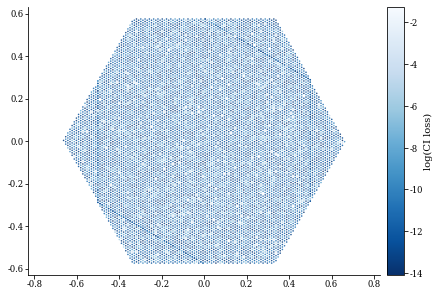

In [21]:
fig = plt.figure(constrained_layout=True)
widths = [1, .05,]
heights = [1,]
pseudo_heatmap_spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

cmap_reversed = matplotlib.cm.get_cmap('Blues_r')

im_ax = fig.add_subplot(pseudo_heatmap_spec[0, 0])
scatter =im_ax.scatter(*model.unit_cell.mesh2(res).T, c=np.log(CI_loss), cmap=cmap_reversed)
im_ax.axis('equal')

cmap_ax = fig.add_subplot(pseudo_heatmap_spec[0, 1])
fig.colorbar(
    scatter,
    cax=cmap_ax, 
    orientation='vertical', 
    cmap=cmap_reversed,
    label="log(CI loss)",
)
cmap_ax.tick_params(pad=2)

In [25]:
print(f"CI loss range: {np.min(CI_loss)} - {np.max(CI_loss)}")

CI loss range: 7.431583526340546e-07 - 0.2867998778820038


## Voronoi decomposition of optimal phase set in Wigner-Seitz cell

In [28]:
model = RobustSimilitude(r_magnitude=r_jitter_magnitude, p_magnitude=p_jitter_magnitude, ncells=N, dtype=dtype)
unit_cell_mesh = model.unit_cell.mesh2(res)
phases = model.phases

array([[-0.5       , -0.28867513],
       [-0.48989899, -0.29450696],
       [-0.47979798, -0.30033878],
       ...,
       [ 0.47979798,  0.30033878],
       [ 0.48989899,  0.29450696],
       [ 0.5       ,  0.28867513]])

In [52]:
g_dist = lambda x: model.unit_cell.geodesic(unit_cell_mesh, x)
geodesic_distances = torch.tensor(g_dist(np.array([[0.4, 0.5], [0.3, 0.1]])))

ValueError: operands could not be broadcast together with shapes (2,7,2) (10000,1,2) 

In [51]:
geodesic_distances.size()

torch.Size([10000])